The purpose of this notebook is to generate color statistics for all objects present in the experiment, and compute an object-level color similarity matrix. It computes average color from prefab 2D texture files.

Unity documentation: 
* https://docs.unity3d.com/Manual/StandardShaderMaterialParameterAlbedoColor.html

Notes: 
* For all texture images that have a .png file attached: 
    - Could also also extract material color and multiply (this adds transparency info)
    - To refine this, could figure out how to ignore extraneous non-transparent back or white pixels (e.g. for "Helmet", "Raw meat"..)
* To get an example for how texture images are generated for materials that don't have a file attached, see keynote "Oil Carafe All"
* Objects for which transparency is important (e.g. oil bottles, oil carafes, water bottles..) might need to be re-examined

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import scipy.interpolate
from matplotlib import animation, rc
from IPython.display import HTML
from scipy.io import loadmat
# import quaternion as qt
import plotly.graph_objects as go
import trimesh
# import pyglet
import itertools
from time import perf_counter 
import pickle
import random
from copy import copy
import cv2
from skimage import io, color
from scipy.stats import spearmanr
from scipy.signal import resample

import visual_search_load
import visual_search_preproc
import visual_search_objects

## 1. Compute raw color representation (can skip to 2 below)

### Get mesh metadata and load scene file.

In [7]:
direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/'
colors_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/objects/Colors/'

## Load first participant's data. 
data_direc, participant_list = visual_search_load.get_direc_participants('Expt2', direc)
participant_id = participant_list[0]
data = visual_search_load.load_processed_data_from_pickle(data_direc, participant_id.split(), ['Behavior','Eye'])

## Get all scenes. 
all_scenes = [x[1] for x in data[0]["Behavior"]["TrialOrder"]]
all_scenes.sort()

## Get all objects.
all_objects = [visual_search_load.get_all_objects(data_direc, x) for x in all_scenes]
unique_objects = np.unique(np.array([item for sublist in all_objects for item in sublist]))
unique_objects.sort()

unique_objects

/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Behavior.txt
/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchData/Expt2/P2_09262018_pickled_processed_Eye.txt


array(['Airplane', 'Allergy Pills', 'Apple', 'Bacon', 'Banana', 'Beans',
       'Block 1', 'Block 10', 'Block 2', 'Block 3', 'Block 4', 'Block 5',
       'Block 6', 'Block 7', 'Block 8', 'Block 9', 'Book 1', 'Book 10',
       'Book 11', 'Book 12', 'Book 2', 'Book 3', 'Book 4', 'Book 5',
       'Book 6', 'Book 7', 'Book 8', 'Book 9', 'Bread', 'Candle',
       'Candlestick', 'Carrot', 'Clipboard', 'Coconut', 'Coffee',
       'Crayon 1', 'Crayon 2', 'Crayon 3', 'Crayon 4', 'Crayon 5',
       'Crayon 6', 'Cup', 'Cylinder 1', 'Cylinder 2', 'Cylinder 3',
       'Cylinder 4', 'Dodecahedron', 'Donut 1', 'Donut 2', 'Eraser',
       'Gold', 'Helmet', 'Juice Box', 'Key', 'Knight', 'Laptop',
       'Left Shoe', 'Magazine 1', 'Magazine 2', 'Marker 1', 'Marker 2',
       'Marker 3', 'Marker 4', 'Milk Carton 1', 'Milk Carton 2',
       'Milk Carton 3', 'Mug', 'Notebook', 'Oil Bottle 1', 'Oil Bottle 2',
       'Oil Carafe 1', 'Oil Carafe 2', 'Paint Can', 'Paper', 'Paper Bag',
       'Paper Box', 'Pear

### Plot example texture.

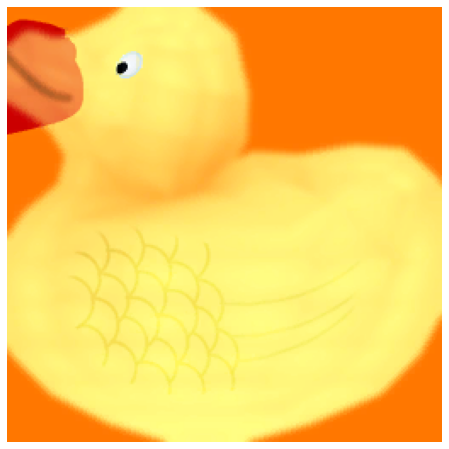

In [8]:
# Select object.
obj = 'Rubber Duck'

# Load color texture.
texture_path = colors_direc + obj + '.png'
im = io.imread(texture_path)

# Plot. 
fig, ax = plt.subplots(figsize=(25,8));
ax.imshow(im)
ax.set_axis_off()

### Convert RGBA to RGB.

In [9]:
im_rgb = color.rgba2rgb(im)
Nsample = im_rgb.shape

def plotMinMax(Xsub_rgb,labels=["R","G","B"]):
    print("______________________________")
    for i, lab in enumerate(labels):
        mi = np.min(Xsub_rgb[:,:,i])
        ma = np.max(Xsub_rgb[:,:,i])
        print("{} : MIN={:8.4f}, MAX={:8.4f}".format(lab,mi,ma))
        
plotMinMax(im_rgb,labels=["R","G","B"])   

______________________________
R : MIN=  0.0000, MAX=  1.0000
G : MIN=  0.0000, MAX=  1.0000
B : MIN=  0.0000, MAX=  1.0000


### Convert RGB to LAB.

______________________________
L : MIN=  0.0000, MAX= 99.4224
A : MIN=-16.9445, MAX= 69.1675
B : MIN=-12.0509, MAX= 76.5723


(-0.5, 255.5, 255.5, -0.5)

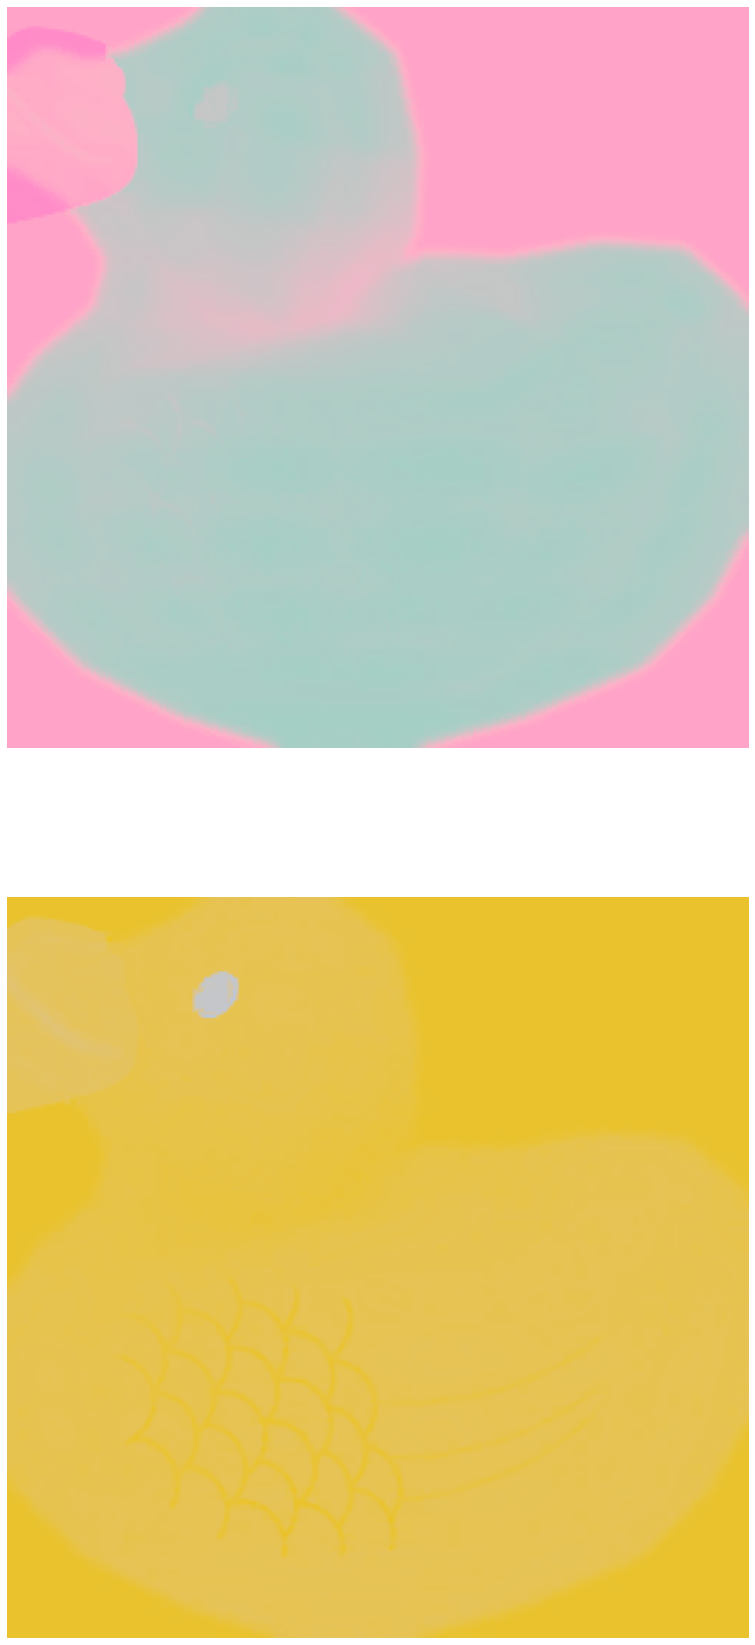

In [10]:
# im_rgb01 = im_rgb/255
im_lab = color.rgb2lab(im_rgb)
plotMinMax(im_lab,labels=["L","A","B"]) 

def extract_single_dim_from_LAB_convert_to_RGB(image,idim):
    '''
    image is a single lab image of shape (None,None,3)
    '''
    z = np.zeros(image.shape)
    if idim != 0 :
        z[:,:,0]=80 # need brightness to plot the image along 1st or 2nd axis
    z[:,:,idim] = image[:,:,idim]
    z = color.lab2rgb(z)
    return(z)

fig, ax = plt.subplots(2, 1, figsize=(60,30))
# lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(im_lab,0) 
# ax[0].imshow(lab_rgb_gray); ax[0].axis("off")
# ax[0].set_title("L: lightness", fontsize=20)

lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(im_lab,1) 
ax[0].imshow(lab_rgb_gray); ax[0].axis("off")
# ax[0].set_title("A: color spectrum (green to red)", fontsize=80)
    
lab_rgb_gray = extract_single_dim_from_LAB_convert_to_RGB(im_lab,2) 
ax[1].imshow(lab_rgb_gray); ax[1].axis("off")
# ax[1].set_title("B: color spectrum (blue to yellow)", fontsize=80);

### Plot color histogram. 

/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


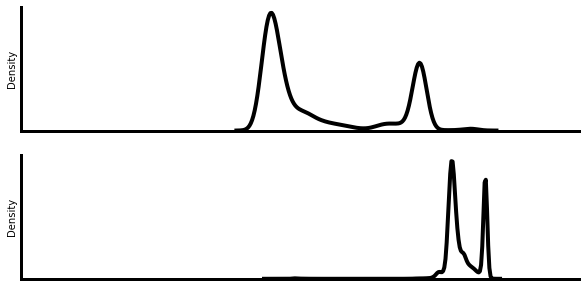

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))
sns.distplot(im_lab[:,:,1].flatten(), color='black', ax=ax1, hist=False, kde_kws={"lw": 4});
sns.distplot(im_lab[:,:,2].flatten(), color='black', ax=ax2, hist=False, kde_kws={"lw": 4});
ax1.tick_params(labelsize=20)
ax2.set_xlim(-110,110)
ax2.tick_params(labelsize=20)
ax1.tick_params(bottom=False)
ax2.tick_params(bottom=False)
for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(3)
  ax2.spines[axis].set_linewidth(3)
ax1.yaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax2.xaxis.set_major_formatter(plt.NullFormatter())
sns.despine();

### Gather textures, convert to LAB and add to list.

In [44]:
L_distribution = []
A_distribution = []
B_distribution = []

L_distribution_rsmp = []
A_distribution_rsmp = []
B_distribution_rsmp = []

for obj_name in unique_objects:
    
    print(obj_name)
    
    ## Load color texture.
    texture_path = colors_direc + obj_name + '.png'
    im = io.imread(texture_path)
 
    ## Resize and convert to LAB.
    side = 500
    im_resized = cv2.resize(im, (side, side))
    im_rgb = color.rgba2rgb(im_resized)
    im_lab = color.rgb2lab(im_rgb)
    
 
    ## Resample LAB representation. 
    n_pixels = im_lab.shape[0] * im_lab.shape[1]
    # Reshape keeps pixels contiguous.  
    lab_all_pixels = np.reshape(im_lab[:,:,[0,1,2]], (n_pixels,3))
     
    L_distribution.append(im_lab[:,:,0].flatten())
    A_distribution.append(im_lab[:,:,1].flatten())
    B_distribution.append(im_lab[:,:,2].flatten())

Airplane
Allergy Pills
Apple
Bacon
Banana
Beans
Block 1
Block 10
Block 2
Block 3
Block 4
Block 5
Block 6
Block 7
Block 8
Block 9
Book 1
Book 10
Book 11
Book 12
Book 2
Book 3
Book 4
Book 5
Book 6
Book 7
Book 8
Book 9
Bread
Candle
Candlestick
Carrot
Clipboard
Coconut
Coffee
Crayon 1
Crayon 2
Crayon 3
Crayon 4
Crayon 5
Crayon 6
Cup
Cylinder 1
Cylinder 2
Cylinder 3
Cylinder 4
Dodecahedron
Donut 1
Donut 2
Eraser
Gold
Helmet
Juice Box
Key
Knight
Laptop
Left Shoe
Magazine 1
Magazine 2
Marker 1
Marker 2
Marker 3
Marker 4
Milk Carton 1
Milk Carton 2
Milk Carton 3
Mug
Notebook
Oil Bottle 1
Oil Bottle 2
Oil Carafe 1
Oil Carafe 2
Paint Can
Paper
Paper Bag
Paper Box
Pear
Pen
Pencil 1
Pencil 2
Phone
Picture 1
Picture 2
Pills
Pizza Box
Plastic Box 1
Plastic Box 2
Raw meat
Right Shoe
Rubber Duck
Scissors
Smartphone
Soccer Ball
Soda Can
Takeout Box
Tea Box
Teabag
Tomato
Towel
Train
Vase 1
Vase 2
Vase 3
Water Bottle
Water Bottle 2
Yogurt


/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/angelaradulescu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


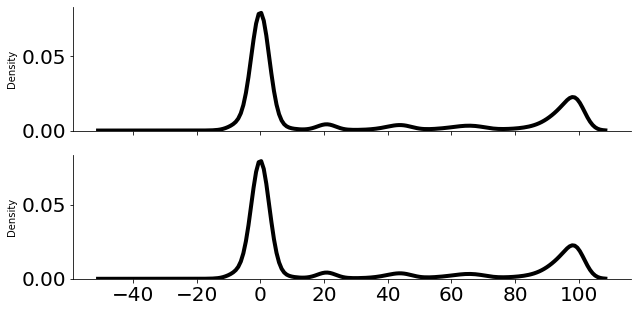

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,5))
sns.distplot(lab_all_pixels, color='black', ax=ax1, hist=False, kde_kws={"lw": 4});
sns.distplot(lab_all_pixels_rsmp, color='black', ax=ax2, hist=False, kde_kws={"lw": 4});
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
sns.despine();

In [48]:
## Define dictionary and pickle. 
lab_all_objects = {"unique_objects": unique_objects, 
                   "L": L_distribution, 
                   "A": A_distribution, 
                   "B": B_distribution, 
                   "L_rsmp": L_distribution_rsmp,
                   "A_rsmp": A_distribution_rsmp,
                   "B_rsmp": B_distribution_rsmp}
pickle_out = open("/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/color/lab_all_objects.pickle","wb")
pickle.dump(lab_all_objects, pickle_out)
pickle_out.close()

## 2. Compute similarity

In [8]:
data_direc = '/Users/angelaradulescu/Dropbox/NYU/Research/TaskVR/VisualSearchGazeData/'
lab_all_objects = pickle.load(open(data_direc + "/color/lab_all_objects.pickle", "rb"))

### Pairwise similarity for all pairs of possible objects.

In [9]:
from scipy.stats import wasserstein_distance

sim_measure = 'l2'

A = lab_all_objects['A']
B = lab_all_objects['B']

n_objects = len(lab_all_objects['unique_objects'])
similarity_matrix = np.zeros((n_objects, n_objects))
object_pairs = list(itertools.combinations(np.arange(n_objects), 2))

t_start = perf_counter()
for p in object_pairs:
    
    # Grab object pair. 
    object_1_idx = p[0]
    object_2_idx = p[1]

    print("Computing" + sim_measure + " distance between " + lab_all_objects['unique_objects'][object_1_idx] + " and " + lab_all_objects['unique_objects'][object_2_idx]) 

    # Concatenate A and B channels.
    AB_object_1 = np.concatenate((A[object_1_idx], B[object_1_idx]))
    AB_object_2 = np.concatenate((A[object_2_idx], B[object_2_idx]))

    # Compute distance. 
    if (sim_measure == "l2"):
        distance = np.linalg.norm(AB_object_1-AB_object_2)
    elif (sim_measure == "spearman"):
        distance = (1-spearmanr(AB_object_1,AB_object_2)[0])/2

    # Record. 
    similarity_matrix[object_1_idx,object_2_idx] = distance

    print("Distance: " + str(distance))
    assert np.isfinite(distance)

t_stop = perf_counter() 
print("Elapsed time for distance computation: ", t_stop-t_start)     

similarity_all_objects = {"unique_objects": lab_all_objects['unique_objects'], "similarity_matrix": similarity_matrix}
pickle_out = open(data_direc + "/color/similarity_" + sim_measure + ".pickle","wb")
pickle.dump(similarity_all_objects, pickle_out)
pickle_out.close()

Computingl2 distance between Airplane and Allergy Pills
Distance: 21222.882203482073
Computingl2 distance between Airplane and Apple
Distance: 17864.733465901045
Computingl2 distance between Airplane and Bacon
Distance: 12067.725615649375
Computingl2 distance between Airplane and Banana
Distance: 12161.098038968044
Computingl2 distance between Airplane and Beans
Distance: 15960.306912246746
Computingl2 distance between Airplane and Block 1
Distance: 12152.6330671512
Computingl2 distance between Airplane and Block 10
Distance: 14070.891258527157
Computingl2 distance between Airplane and Block 2
Distance: 12431.040443736183
Computingl2 distance between Airplane and Block 3
Distance: 12637.957585705133
Computingl2 distance between Airplane and Block 4
Distance: 12148.104455215267
Computingl2 distance between Airplane and Block 5
Distance: 12348.45488776619
Computingl2 distance between Airplane and Block 6
Distance: 14002.0325581116
Computingl2 distance between Airplane and Block 7
Distanc

Distance: 24872.28980165837
Computingl2 distance between Allergy Pills and Block 6
Distance: 25981.978626659755
Computingl2 distance between Allergy Pills and Block 7
Distance: 25923.576440588044
Computingl2 distance between Allergy Pills and Block 8
Distance: 26072.723642364836
Computingl2 distance between Allergy Pills and Block 9
Distance: 25798.82318285042
Computingl2 distance between Allergy Pills and Book 1
Distance: 24499.595708506185
Computingl2 distance between Allergy Pills and Book 10
Distance: 21020.433692826693
Computingl2 distance between Allergy Pills and Book 11
Distance: 14941.301840516193
Computingl2 distance between Allergy Pills and Book 12
Distance: 17996.210815441253
Computingl2 distance between Allergy Pills and Book 2
Distance: 15928.956316755326
Computingl2 distance between Allergy Pills and Book 3
Distance: 24790.966135015224
Computingl2 distance between Allergy Pills and Book 4
Distance: 17773.863845812917
Computingl2 distance between Allergy Pills and Book 5

Distance: 34529.265621481696
Computingl2 distance between Apple and Gold
Distance: 21046.411392733924
Computingl2 distance between Apple and Helmet
Distance: 33409.910166130016
Computingl2 distance between Apple and Juice Box
Distance: 39386.49803540994
Computingl2 distance between Apple and Key
Distance: 28898.073200827366
Computingl2 distance between Apple and Knight
Distance: 28434.896339254276
Computingl2 distance between Apple and Laptop
Distance: 28924.409041779552
Computingl2 distance between Apple and Left Shoe
Distance: 28747.004782335396
Computingl2 distance between Apple and Magazine 1
Distance: 30279.013928202607
Computingl2 distance between Apple and Magazine 2
Distance: 30279.013928202607
Computingl2 distance between Apple and Marker 1
Distance: 26153.385539240477
Computingl2 distance between Apple and Marker 2
Distance: 57390.6787482946
Computingl2 distance between Apple and Marker 3
Distance: 28898.366466084117
Computingl2 distance between Apple and Marker 4
Distance: 3

Distance: 18299.630758607735
Computingl2 distance between Bacon and Right Shoe
Distance: 14477.558700481914
Computingl2 distance between Bacon and Rubber Duck
Distance: 26819.748668160642
Computingl2 distance between Bacon and Scissors
Distance: 14547.709957705663
Computingl2 distance between Bacon and Smartphone
Distance: 16360.72779805148
Computingl2 distance between Bacon and Soccer Ball
Distance: 14547.756587814469
Computingl2 distance between Bacon and Soda Can
Distance: 23145.249982268513
Computingl2 distance between Bacon and Takeout Box
Distance: 13851.648623171463
Computingl2 distance between Bacon and Tea Box
Distance: 13544.752750753214
Computingl2 distance between Bacon and Teabag
Distance: 16625.160045504643
Computingl2 distance between Bacon and Tomato
Distance: 20242.186514970446
Computingl2 distance between Bacon and Towel
Distance: 14547.56609960839
Computingl2 distance between Bacon and Train
Distance: 17705.822658406567
Computingl2 distance between Bacon and Vase 1
D

Distance: 11497.741282448802
Computingl2 distance between Beans and Book 9
Distance: 13128.046597368957
Computingl2 distance between Beans and Bread
Distance: 19911.234909274655
Computingl2 distance between Beans and Candle
Distance: 11240.504262899392
Computingl2 distance between Beans and Candlestick
Distance: 10845.490700416456
Computingl2 distance between Beans and Carrot
Distance: 21346.058268012555
Computingl2 distance between Beans and Clipboard
Distance: 11194.41323752951
Computingl2 distance between Beans and Coconut
Distance: 12605.352104885947
Computingl2 distance between Beans and Coffee
Distance: 17420.074619142128
Computingl2 distance between Beans and Crayon 1
Distance: 21961.336543296635
Computingl2 distance between Beans and Crayon 2
Distance: 24253.589626087236
Computingl2 distance between Beans and Crayon 3
Distance: 25581.068691111414
Computingl2 distance between Beans and Crayon 4
Distance: 23951.05931507598
Computingl2 distance between Beans and Crayon 5
Distance:

Distance: 24242.78479068742
Computingl2 distance between Block 1 and Magazine 2
Distance: 24242.78479068742
Computingl2 distance between Block 1 and Marker 1
Distance: 27002.897240496128
Computingl2 distance between Block 1 and Marker 2
Distance: 55388.56712011546
Computingl2 distance between Block 1 and Marker 3
Distance: 22430.402462896946
Computingl2 distance between Block 1 and Marker 4
Distance: 28462.571964724226
Computingl2 distance between Block 1 and Milk Carton 1
Distance: 24443.7665283947
Computingl2 distance between Block 1 and Milk Carton 2
Distance: 24443.7665283947
Computingl2 distance between Block 1 and Milk Carton 3
Distance: 24443.7665283947
Computingl2 distance between Block 1 and Mug
Distance: 23940.40423921733
Computingl2 distance between Block 1 and Notebook
Distance: 21542.67561632865
Computingl2 distance between Block 1 and Oil Bottle 1
Distance: 16193.630166415738
Computingl2 distance between Block 1 and Oil Bottle 2
Distance: 16440.643345371325
Computingl2 di

Distance: 25680.318855854945
Computingl2 distance between Block 10 and Right Shoe
Distance: 23776.8809853444
Computingl2 distance between Block 10 and Rubber Duck
Distance: 22508.506987806533
Computingl2 distance between Block 10 and Scissors
Distance: 23848.23792438947
Computingl2 distance between Block 10 and Smartphone
Distance: 26049.279882134346
Computingl2 distance between Block 10 and Soccer Ball
Distance: 23848.408977969808
Computingl2 distance between Block 10 and Soda Can
Distance: 29924.29935761328
Computingl2 distance between Block 10 and Takeout Box
Distance: 23535.638108365332
Computingl2 distance between Block 10 and Tea Box
Distance: 16167.96065967321
Computingl2 distance between Block 10 and Teabag
Distance: 25847.955404545144
Computingl2 distance between Block 10 and Tomato
Distance: 19432.159666809952
Computingl2 distance between Block 10 and Towel
Distance: 23847.86934467868
Computingl2 distance between Block 10 and Train
Distance: 22487.620521712426
Computingl2 dis

Distance: 22497.109037925107
Computingl2 distance between Block 3 and Cup
Distance: 27884.8937326956
Computingl2 distance between Block 3 and Cylinder 1
Distance: 20905.30874254592
Computingl2 distance between Block 3 and Cylinder 2
Distance: 20019.29517815776
Computingl2 distance between Block 3 and Cylinder 3
Distance: 17230.29009651508
Computingl2 distance between Block 3 and Cylinder 4
Distance: 23685.236322792287
Computingl2 distance between Block 3 and Dodecahedron
Distance: 22496.485929366125
Computingl2 distance between Block 3 and Donut 1
Distance: 15738.010137333511
Computingl2 distance between Block 3 and Donut 2
Distance: 18779.946014287918
Computingl2 distance between Block 3 and Eraser
Distance: 31775.97044392431
Computingl2 distance between Block 3 and Gold
Distance: 13978.045348920477
Computingl2 distance between Block 3 and Helmet
Distance: 27714.879927143087
Computingl2 distance between Block 3 and Juice Box
Distance: 38346.215756482736
Computingl2 distance between Bl

Distance: 21883.413719868113
Computingl2 distance between Block 4 and Scissors
Distance: 22451.32015813692
Computingl2 distance between Block 4 and Smartphone
Distance: 24705.145963548475
Computingl2 distance between Block 4 and Soccer Ball
Distance: 22451.466640541876
Computingl2 distance between Block 4 and Soda Can
Distance: 28778.64972250611
Computingl2 distance between Block 4 and Takeout Box
Distance: 22082.323422389643
Computingl2 distance between Block 4 and Tea Box
Distance: 14526.887851115476
Computingl2 distance between Block 4 and Teabag
Distance: 24500.26473404823
Computingl2 distance between Block 4 and Tomato
Distance: 18608.4607078731
Computingl2 distance between Block 4 and Towel
Distance: 22450.946585331785
Computingl2 distance between Block 4 and Train
Distance: 21122.795813536377
Computingl2 distance between Block 4 and Vase 1
Distance: 22373.254230446033
Computingl2 distance between Block 4 and Vase 2
Distance: 22373.254230446033
Computingl2 distance between Block 

Distance: 17876.799483438062
Computingl2 distance between Block 6 and Cylinder 4
Distance: 25003.07328301571
Computingl2 distance between Block 6 and Dodecahedron
Distance: 23761.41736799763
Computingl2 distance between Block 6 and Donut 1
Distance: 17279.814833478722
Computingl2 distance between Block 6 and Donut 2
Distance: 20215.61703930377
Computingl2 distance between Block 6 and Eraser
Distance: 32762.485326683927
Computingl2 distance between Block 6 and Gold
Distance: 14846.822172779308
Computingl2 distance between Block 6 and Helmet
Distance: 28878.917345017777
Computingl2 distance between Block 6 and Juice Box
Distance: 39627.06714546657
Computingl2 distance between Block 6 and Key
Distance: 23761.643358721907
Computingl2 distance between Block 6 and Knight
Distance: 23273.92737253483
Computingl2 distance between Block 6 and Laptop
Distance: 23788.328289308327
Computingl2 distance between Block 6 and Left Shoe
Distance: 23693.712051660033
Computingl2 distance between Block 6 an

Distance: 22884.452028029613
Computingl2 distance between Block 7 and Plastic Box 1
Distance: 16458.50677441239
Computingl2 distance between Block 7 and Plastic Box 2
Distance: 20460.425799331668
Computingl2 distance between Block 7 and Raw meat
Distance: 25610.308038911033
Computingl2 distance between Block 7 and Right Shoe
Distance: 23700.2909159848
Computingl2 distance between Block 7 and Rubber Duck
Distance: 22531.54386149224
Computingl2 distance between Block 7 and Scissors
Distance: 23766.088612601303
Computingl2 distance between Block 7 and Smartphone
Distance: 25972.493776959134
Computingl2 distance between Block 7 and Soccer Ball
Distance: 23766.265940023655
Computingl2 distance between Block 7 and Soda Can
Distance: 29834.800735090084
Computingl2 distance between Block 7 and Takeout Box
Distance: 23479.306753855813
Computingl2 distance between Block 7 and Tea Box
Distance: 16106.774718182991
Computingl2 distance between Block 7 and Teabag
Distance: 25759.304469557286
Computi

Distance: 21135.143587045815
Computingl2 distance between Block 9 and Cylinder 3
Distance: 18093.6921332737
Computingl2 distance between Block 9 and Cylinder 4
Distance: 25032.25641659554
Computingl2 distance between Block 9 and Dodecahedron
Distance: 23779.602457894805
Computingl2 distance between Block 9 and Donut 1
Distance: 17214.91934969464
Computingl2 distance between Block 9 and Donut 2
Distance: 20193.875009113344
Computingl2 distance between Block 9 and Eraser
Distance: 32820.344751784825
Computingl2 distance between Block 9 and Gold
Distance: 15003.765021813873
Computingl2 distance between Block 9 and Helmet
Distance: 28886.753538787965
Computingl2 distance between Block 9 and Juice Box
Distance: 39483.39289225717
Computingl2 distance between Block 9 and Key
Distance: 23779.841915190635
Computingl2 distance between Block 9 and Knight
Distance: 23278.404400353993
Computingl2 distance between Block 9 and Laptop
Distance: 23806.92482573509
Computingl2 distance between Block 9 an

Distance: 21731.958995658944
Computingl2 distance between Book 1 and Takeout Box
Distance: 19624.352882633222
Computingl2 distance between Book 1 and Tea Box
Distance: 17565.202823812142
Computingl2 distance between Book 1 and Teabag
Distance: 20133.4494169994
Computingl2 distance between Book 1 and Tomato
Distance: 29064.51629567431
Computingl2 distance between Book 1 and Towel
Distance: 19003.889494762014
Computingl2 distance between Book 1 and Train
Distance: 27566.20305040083
Computingl2 distance between Book 1 and Vase 1
Distance: 18960.39582551226
Computingl2 distance between Book 1 and Vase 2
Distance: 18960.39582551226
Computingl2 distance between Book 1 and Vase 3
Distance: 19092.912041812007
Computingl2 distance between Book 1 and Water Bottle
Distance: 21275.220859128363
Computingl2 distance between Book 1 and Water Bottle 2
Distance: 20869.58088426477
Computingl2 distance between Book 1 and Yogurt
Distance: 18760.676831555607
Computingl2 distance between Book 10 and Book 11

Distance: 22023.071666954187
Computingl2 distance between Book 11 and Marker 2
Distance: 42054.07045034498
Computingl2 distance between Book 11 and Marker 3
Distance: 10051.663388282861
Computingl2 distance between Book 11 and Marker 4
Distance: 33702.17235008749
Computingl2 distance between Book 11 and Milk Carton 1
Distance: 13421.54181906913
Computingl2 distance between Book 11 and Milk Carton 2
Distance: 13421.54181906913
Computingl2 distance between Book 11 and Milk Carton 3
Distance: 13421.54181906913
Computingl2 distance between Book 11 and Mug
Distance: 28136.8631919857
Computingl2 distance between Book 11 and Notebook
Distance: 12026.948063931317
Computingl2 distance between Book 11 and Oil Bottle 1
Distance: 12167.466772898671
Computingl2 distance between Book 11 and Oil Bottle 2
Distance: 12067.32626812444
Computingl2 distance between Book 11 and Oil Carafe 1
Distance: 8221.70262941108
Computingl2 distance between Book 11 and Oil Carafe 2
Distance: 8221.70262941108
Computing

Distance: 6432.538952482614
Computingl2 distance between Book 12 and Vase 3
Distance: 6513.312323537351
Computingl2 distance between Book 12 and Water Bottle
Distance: 9256.334548622204
Computingl2 distance between Book 12 and Water Bottle 2
Distance: 9287.564789569344
Computingl2 distance between Book 12 and Yogurt
Distance: 9107.294862278843
Computingl2 distance between Book 2 and Book 3
Distance: 21618.697762043284
Computingl2 distance between Book 2 and Book 4
Distance: 8004.445611867162
Computingl2 distance between Book 2 and Book 5
Distance: 5767.999444237604
Computingl2 distance between Book 2 and Book 6
Distance: 10613.894790732476
Computingl2 distance between Book 2 and Book 7
Distance: 21618.697762043284
Computingl2 distance between Book 2 and Book 8
Distance: 2868.4668005245453
Computingl2 distance between Book 2 and Book 9
Distance: 11566.359055864492
Computingl2 distance between Book 2 and Bread
Distance: 23620.010175788815
Computingl2 distance between Book 2 and Candle
Di

Distance: 18377.562546630834
Computingl2 distance between Book 3 and Paint Can
Distance: 27502.003538288416
Computingl2 distance between Book 3 and Paper
Distance: 21632.216561815407
Computingl2 distance between Book 3 and Paper Bag
Distance: 21025.236641348547
Computingl2 distance between Book 3 and Paper Box
Distance: 27436.35415195415
Computingl2 distance between Book 3 and Pear
Distance: 25457.73743786081
Computingl2 distance between Book 3 and Pen
Distance: 32231.85972363128
Computingl2 distance between Book 3 and Pencil 1
Distance: 29324.327472608504
Computingl2 distance between Book 3 and Pencil 2
Distance: 43290.02511828106
Computingl2 distance between Book 3 and Phone
Distance: 21616.00925322762
Computingl2 distance between Book 3 and Picture 1
Distance: 21495.071443526544
Computingl2 distance between Book 3 and Picture 2
Distance: 21314.72884337979
Computingl2 distance between Book 3 and Pills
Distance: 23029.145666024557
Computingl2 distance between Book 3 and Pizza Box
Dist

Distance: 24081.864145264157
Computingl2 distance between Book 5 and Cylinder 3
Distance: 22466.92282473749
Computingl2 distance between Book 5 and Cylinder 4
Distance: 10999.288931660916
Computingl2 distance between Book 5 and Dodecahedron
Distance: 5754.252800815345
Computingl2 distance between Book 5 and Donut 1
Distance: 15208.12915060824
Computingl2 distance between Book 5 and Donut 2
Distance: 6797.518276262071
Computingl2 distance between Book 5 and Eraser
Distance: 25682.880524322034
Computingl2 distance between Book 5 and Gold
Distance: 23172.805249225363
Computingl2 distance between Book 5 and Helmet
Distance: 11764.615254969185
Computingl2 distance between Book 5 and Juice Box
Distance: 26310.873764403186
Computingl2 distance between Book 5 and Key
Distance: 5754.288376866483
Computingl2 distance between Book 5 and Knight
Distance: 6062.253491801317
Computingl2 distance between Book 5 and Laptop
Distance: 5764.805914345701
Computingl2 distance between Book 5 and Left Shoe
Di

Distance: 12414.569502915863
Computingl2 distance between Book 6 and Teabag
Distance: 12807.234519899395
Computingl2 distance between Book 6 and Tomato
Distance: 22776.38462511903
Computingl2 distance between Book 6 and Towel
Distance: 10619.520448397678
Computingl2 distance between Book 6 and Train
Distance: 20575.19708041789
Computingl2 distance between Book 6 and Vase 1
Distance: 10564.974841884683
Computingl2 distance between Book 6 and Vase 2
Distance: 10564.974841884683
Computingl2 distance between Book 6 and Vase 3
Distance: 10767.72061885818
Computingl2 distance between Book 6 and Water Bottle
Distance: 14300.759829932133
Computingl2 distance between Book 6 and Water Bottle 2
Distance: 13623.955441893608
Computingl2 distance between Book 6 and Yogurt
Distance: 11015.506944850928
Computingl2 distance between Book 7 and Book 8
Distance: 21598.070746924037
Computingl2 distance between Book 7 and Book 9
Distance: 24292.066788572323
Computingl2 distance between Book 7 and Bread
Dist

Distance: 12540.414235410633
Computingl2 distance between Book 8 and Oil Bottle 2
Distance: 12412.456343231283
Computingl2 distance between Book 8 and Oil Carafe 1
Distance: 6711.278673579022
Computingl2 distance between Book 8 and Oil Carafe 2
Distance: 6711.278673579022
Computingl2 distance between Book 8 and Paint Can
Distance: 24704.920959454594
Computingl2 distance between Book 8 and Paper
Distance: 2842.907772070986
Computingl2 distance between Book 8 and Paper Bag
Distance: 17188.320842495606
Computingl2 distance between Book 8 and Paper Box
Distance: 23776.06589965983
Computingl2 distance between Book 8 and Pear
Distance: 29334.290689865647
Computingl2 distance between Book 8 and Pen
Distance: 30363.240776699768
Computingl2 distance between Book 8 and Pencil 1
Distance: 24209.23758556929
Computingl2 distance between Book 8 and Pencil 2
Distance: 30094.744904002586
Computingl2 distance between Book 8 and Phone
Distance: 2874.1127975260656
Computingl2 distance between Book 8 and 

Distance: 29003.722830716793
Computingl2 distance between Bread and Juice Box
Distance: 36577.954426215576
Computingl2 distance between Bread and Key
Distance: 23622.797932033056
Computingl2 distance between Bread and Knight
Distance: 23020.731287038394
Computingl2 distance between Bread and Laptop
Distance: 23653.624643714655
Computingl2 distance between Bread and Left Shoe
Distance: 23508.99043887655
Computingl2 distance between Bread and Magazine 1
Distance: 26197.307651277868
Computingl2 distance between Bread and Magazine 2
Distance: 26197.307651277868
Computingl2 distance between Bread and Marker 1
Distance: 24260.233943522184
Computingl2 distance between Bread and Marker 2
Distance: 53685.70952204207
Computingl2 distance between Bread and Marker 3
Distance: 23623.080506818915
Computingl2 distance between Bread and Marker 4
Distance: 32579.888936444306
Computingl2 distance between Bread and Milk Carton 1
Distance: 25733.092800293845
Computingl2 distance between Bread and Milk Car

KeyboardInterrupt: 

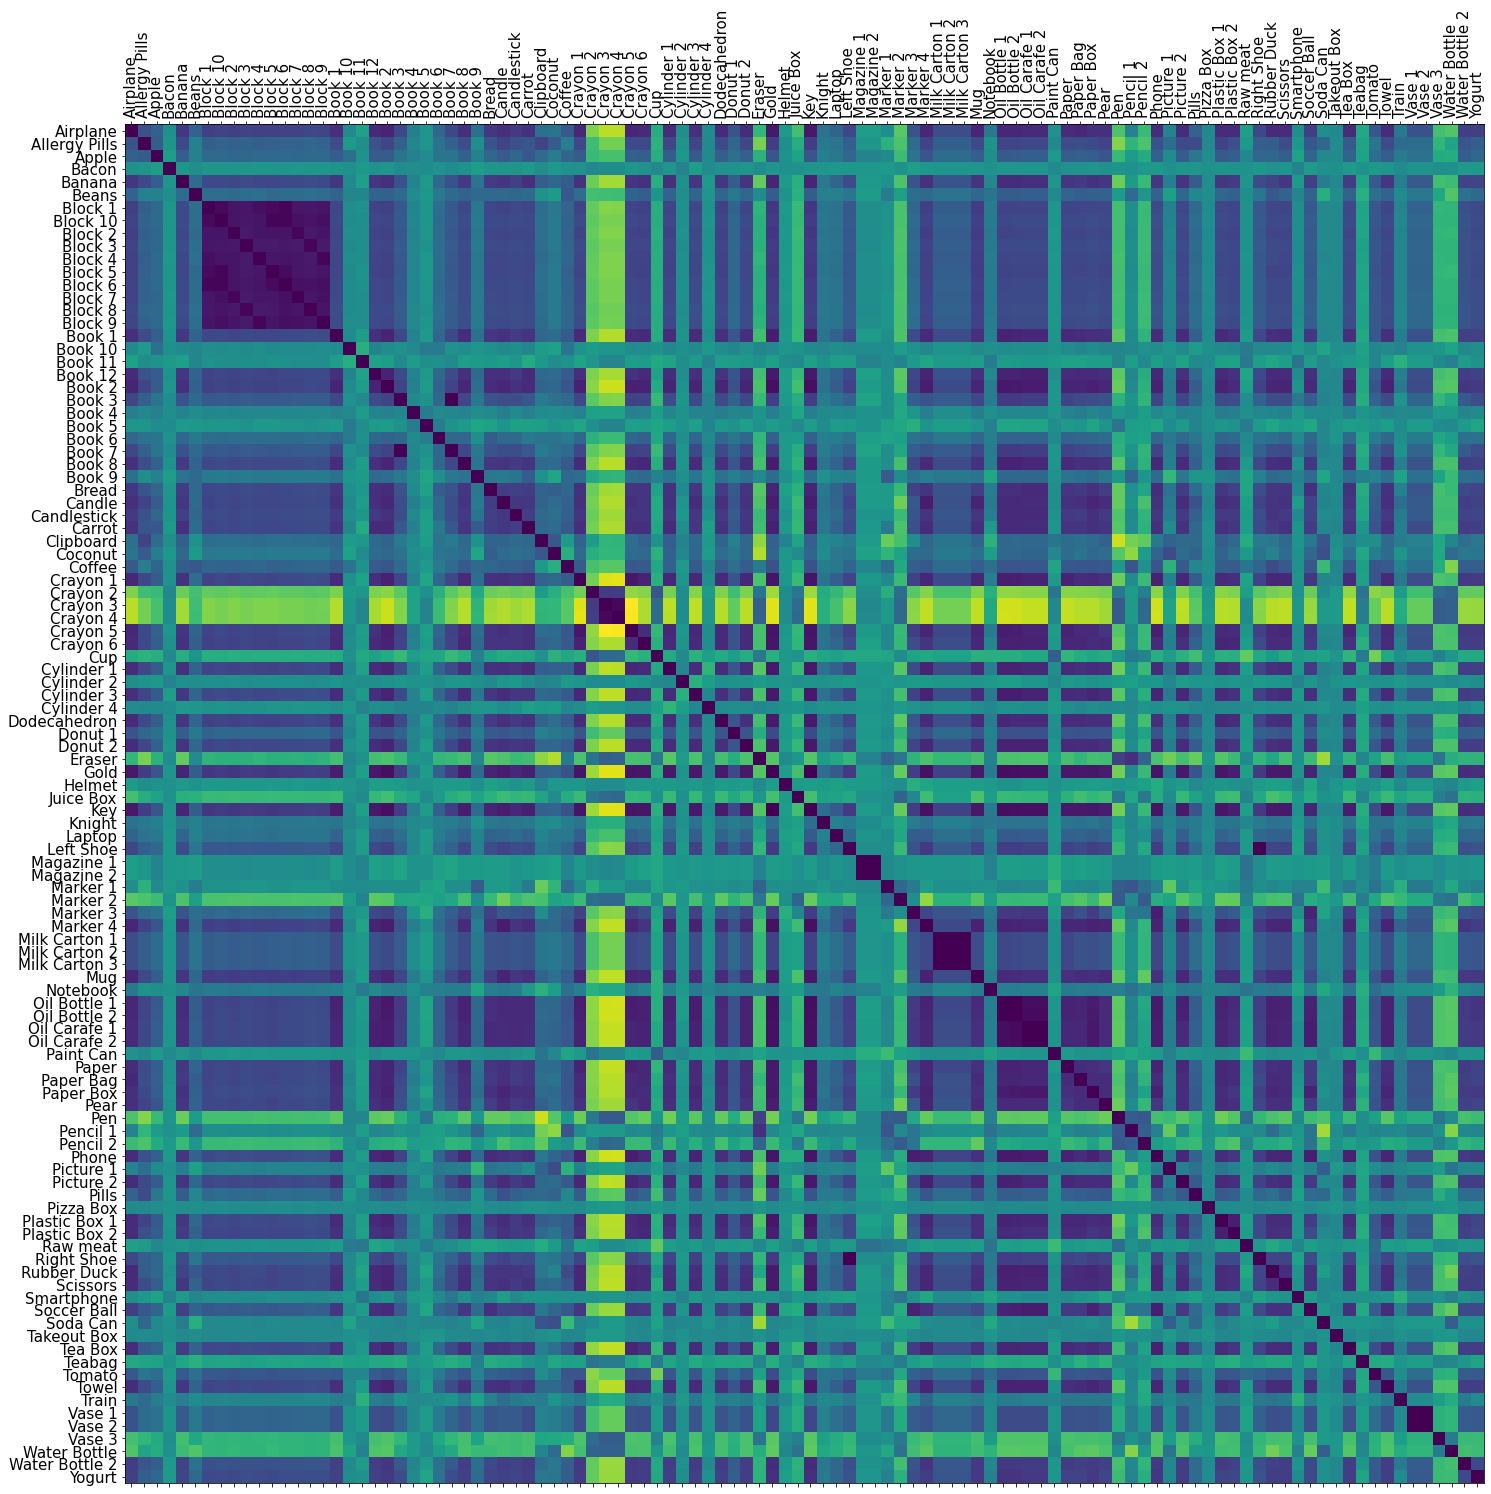

In [60]:
## Plot similarity matrix. 
unique_objects = lab_all_objects['unique_objects']
similarity_matrix_full = similarity_all_objects['similarity_matrix'] + similarity_all_objects['similarity_matrix'].T 

fig, ax = plt.subplots(figsize=(25,25))
cax = ax.matshow(similarity_matrix_full, cmap='viridis')
ax.set_xticks(np.arange(len(unique_objects)))
ax.set_xticklabels(unique_objects)
ax.set_yticks(np.arange(len(unique_objects)))
ax.set_yticklabels(unique_objects)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.show()